In [1]:
%load_ext autoreload
%autoreload 2
from model import scVI_final as scVI
from model.vae import format_time
import tensorflow as tf
from benchmarking import *
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import time

In [8]:
data_path = "/home/ubuntu/single-cell/10x1Mcells/data.hdf5"
import h5py
f = h5py.File(data_path)
expression_train = f["data_train"][:10000]
expression_test = f["data_test"][:10000]
import matplotlib.pyplot as plt
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

In [3]:
def next_batch(data, batch_size):
    index = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    return data[index]

In [4]:
def eval_likelihood(data, sess, kl=1):
    s = 0
    for i in range(10):
        dic_full = {expression: data[1000 * i: 1000 * (i+ 1)], training_phase:False, kl_scalar:kl}
        s += sess.run(model.loss, feed_dict=dic_full) 
    return s / 10.

In [5]:
def train_model(num_epochs, expression_train, expression_test, step, batch_size, impute=False):
    iterep = int(expression_train.shape[0]/float(batch_size))-1
    training_history = {"t_loss":[], "v_loss":[], "time":[], "epoch":[], "impute":[]}
    training_history["n_hidden"] = model.n_hidden
    training_history["model"] = model.__class__.__name__
    training_history["n_input"] = model.n_input
    training_history["dropout_nn"] = model.dropout_rate
    training_history["learning_rate"] = learning_rate
    training_history["dispersion"] = model.complex_dispersion
    training_history["epsilon"] = epsilon
    training_history["n_layers"] = model.n_layers
    begin = time.time()
    
    
    for t in range(iterep * num_epochs):
    
        # arange data in batches
        #x_train, b_train = next_batch(expression_train, batch_train, batch_size)
        #x_test, b_test = next_batch(expression_test, batch_test, batch_size)

        #prepare data dictionaries
        #dic_train = {expression: x_train, batch:b_train.A, training_phase:True, kl_scalar:0}
        #dic_test = {expression: x_test, batch:b_test.A, training_phase:False, kl_scalar:0}
        
        # arange data in batches
        #x_train = next_batch(expression_train, batch_size).astype(np.float32)
        x_train = expression_train[batch_size * (t%iterep) :batch_size * (t%iterep + 1) ].astype(np.float32)
        x_test = next_batch(expression_test, batch_size).astype(np.float32)

        #prepare data dictionaries
        dic_train = {expression: x_train, training_phase:True, kl_scalar:0}
        dic_test = {expression: x_test,  training_phase:False, kl_scalar:0} 
        
        # run an optimization set
        _, l_tr = sess.run([step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:
            now = time.time()
            print epoch

            l_t = sess.run((model.loss), feed_dict=dic_test)

            training_history["t_loss"].append(l_tr)
            training_history["v_loss"].append(l_t)
            training_history["time"].append(format_time(int(now-begin)))
            training_history["epoch"].append(epoch)
            
            print 'Train / Test performance:', l_tr, l_t
            print "Elapsed Time:", training_history["time"][-1]
            
            if impute:
                training_history["impute"].append(eval_imputed_data(model))
            if np.isnan(l_tr):
                break
    return training_history

# Vizualisation of one training curve

In [27]:
n_cells = 10000
expression_train = f["data_train"][:n_cells]
batch_size = 128
learning_rate = 0.005
epsilon = 0.01

res = {}

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var, \
                          n_layers=1, n_hidden=128)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

history = train_model(200, expression_train, expression_test, model.train_step, batch_size)

[<tf.Variable 'variational_distribution/fully_connected/weights:0' shape=(720, 128) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/batch_normalization/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/batch_normalization/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_1/weights:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_1/biases:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_2/weights:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_2/biases:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_3/weights:0' shape=(720, 128) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_3/biases:0' shape=(128,) dtype=

99
Train / Test performance: 1155.81 1187.12
Elapsed Time: 0:01:14
100
Train / Test performance: 1161.29 1120.51
Elapsed Time: 0:01:15
101
Train / Test performance: 1156.75 1145.26
Elapsed Time: 0:01:15
102
Train / Test performance: 1155.98 1162.94
Elapsed Time: 0:01:16
103
Train / Test performance: 1155.34 1174.4
Elapsed Time: 0:01:17
104
Train / Test performance: 1163.8 1142.13
Elapsed Time: 0:01:18
105
Train / Test performance: 1157.51 1151.36
Elapsed Time: 0:01:18
106
Train / Test performance: 1158.57 1143.47
Elapsed Time: 0:01:19
107
Train / Test performance: 1157.15 1223.6
Elapsed Time: 0:01:20
108
Train / Test performance: 1158.61 1204.9
Elapsed Time: 0:01:21
109
Train / Test performance: 1154.25 1163.17
Elapsed Time: 0:01:21
110
Train / Test performance: 1159.54 1163.21
Elapsed Time: 0:01:22
111
Train / Test performance: 1155.73 1132.13
Elapsed Time: 0:01:23
112
Train / Test performance: 1158.42 1098.92
Elapsed Time: 0:01:24
113
Train / Test performance: 1163.0 1155.55
Elapsed 

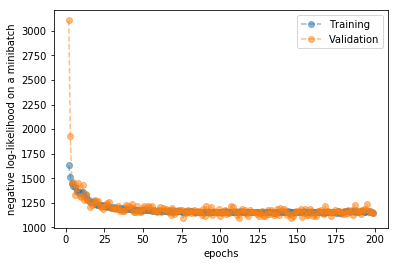

In [29]:
plt.plot(history["epoch"][2:], history["t_loss"][2:],  marker='o', linestyle='--',label="Training", alpha=0.5)
plt.plot(history["epoch"][2:], history["v_loss"][2:],  marker='o', linestyle='--',label="Validation", alpha=0.5)
plt.legend()
plt.ylabel("negative log-likelihood on a minibatch")
plt.xlabel("epochs")
plt.savefig("training_curves.pdf", dpi=300)
plt.show()

In [10]:
def eval_latent(data, sess, model, combine=False):
    dic_full = {expression: data, training_phase:False, kl_scalar:1}
    if model.__class__.__name__ == 'scVIModel':
        temp = sess.run(model.sampling_latent, feed_dict=dic_full)
        if combine:
            return np.hstack((temp[0], (temp[1] - mean) / np.sqrt(var)))
        else:
            return temp[0]
    else:
        return sess.run(model.sampling_latent, feed_dict=dic_full)

# imputation along a training curve

In [31]:
data_path = "/home/ubuntu/single-cell-scVI/data/10x1M/"
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
        np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")

In [55]:
n_cells = 10000
expression_train = f["data_train"][:n_cells].astype(np.float32)
batch_size = 128
learning_rate = 0.005
epsilon = 0.01

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var, \
                          n_layers=1, n_hidden=128)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

[<tf.Variable 'variational_distribution/fully_connected/weights:0' shape=(720, 128) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/batch_normalization/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/batch_normalization/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_1/weights:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_1/biases:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_2/weights:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_2/biases:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_3/weights:0' shape=(720, 128) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_3/biases:0' shape=(128,) dtype=

In [56]:
def eval_imputed_data(model):
    dic_zero = {expression: X_zero, training_phase:False, kl_scalar:1.} 
    zero_, dropout_, rate_  = sess.run((model.zero_prob, model.dropout_prob, model.px_rate), \
                                       feed_dict=dic_zero)
    return imputation_error(rate_, expression_train, X_zero, i, j, ix)

In [57]:
history_impute = train_model(200, X_zero, expression_test, model.train_step, batch_size, impute=True)

0
Train / Test performance: 16871.9 4298.65
Elapsed Time: 0:00:00
1
Train / Test performance: 1645.02 2581.86
Elapsed Time: 0:00:01
2
Train / Test performance: 1492.91 2205.66
Elapsed Time: 0:00:01
3
Train / Test performance: 1439.62 1565.8
Elapsed Time: 0:00:02
4
Train / Test performance: 1440.64 1494.36
Elapsed Time: 0:00:03
5
Train / Test performance: 1385.36 1410.41
Elapsed Time: 0:00:04
6
Train / Test performance: 1384.24 1475.79
Elapsed Time: 0:00:05
7
Train / Test performance: 1345.96 1391.68
Elapsed Time: 0:00:06
8
Train / Test performance: 1330.05 1459.76
Elapsed Time: 0:00:07
9
Train / Test performance: 1321.47 1409.06
Elapsed Time: 0:00:08
10
Train / Test performance: 1303.69 1389.54
Elapsed Time: 0:00:09
11
Train / Test performance: 1295.87 1373.27
Elapsed Time: 0:00:09
12
Train / Test performance: 1275.47 1364.02
Elapsed Time: 0:00:10
13
Train / Test performance: 1276.48 1362.0
Elapsed Time: 0:00:11
14
Train / Test performance: 1256.24 1255.92
Elapsed Time: 0:00:12
15
Trai

123
Train / Test performance: 1147.73 1184.7
Elapsed Time: 0:01:46
124
Train / Test performance: 1149.98 1163.83
Elapsed Time: 0:01:46
125
Train / Test performance: 1150.66 1191.78
Elapsed Time: 0:01:47
126
Train / Test performance: 1151.34 1187.08
Elapsed Time: 0:01:48
127
Train / Test performance: 1146.6 1190.9
Elapsed Time: 0:01:49
128
Train / Test performance: 1149.84 1178.59
Elapsed Time: 0:01:50
129
Train / Test performance: 1150.9 1200.19
Elapsed Time: 0:01:51
130
Train / Test performance: 1151.06 1217.45
Elapsed Time: 0:01:52
131
Train / Test performance: 1147.88 1249.45
Elapsed Time: 0:01:52
132
Train / Test performance: 1146.78 1164.47
Elapsed Time: 0:01:53
133
Train / Test performance: 1148.59 1180.99
Elapsed Time: 0:01:54
134
Train / Test performance: 1156.98 1181.07
Elapsed Time: 0:01:55
135
Train / Test performance: 1148.36 1176.64
Elapsed Time: 0:01:56
136
Train / Test performance: 1146.97 1224.73
Elapsed Time: 0:01:57
137
Train / Test performance: 1151.56 1181.3
Elapsed

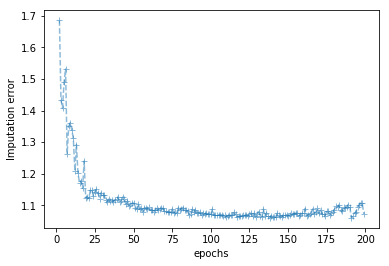

In [87]:
plt.plot(history_impute["epoch"][1:], history_impute["impute"][1:],  marker='+', linestyle="--", alpha=0.5)
plt.ylabel("Imputation error")
plt.xlabel("epochs")
plt.savefig("Imputation_stability.pdf", dpi=300)
plt.show()

# Imputation for same number of epochs, different latent dimension for 5 seeds

In [60]:
batch_size = 128
learning_rate = 0.005
epsilon = 0.01

range_d = [2, 5, 7, 10, 12, 15, 20, 30]
results = {}


for d in range_d:
    results[d] = []
    for n in [0, 0, 0, 0]:
        tf.reset_default_graph()
        expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
        kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
        training_phase = tf.placeholder(tf.bool, (), name='training_phase')

        model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                                 optimize_algo=optimizer, phase=training_phase, \
                                  library_size_mean=mean, library_size_var=var, \
                                  n_layers=1, n_hidden=128, n_latent=d)

        # Session creation
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        train_model(120, X_zero, expression_test, model.train_step, batch_size)
        results[d].append(eval_imputed_data(model))

[<tf.Variable 'variational_distribution/fully_connected/weights:0' shape=(720, 128) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/batch_normalization/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/batch_normalization/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_1/weights:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_1/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_2/weights:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_3/weights:0' shape=(720, 128) dtype=float32_ref>, <tf.Variable 'variational_distribution/fully_connected_3/biases:0' shape=(128,) dtype=floa

99
Train / Test performance: 1197.24 1211.11
Elapsed Time: 0:01:16
100
Train / Test performance: 1192.84 1229.83
Elapsed Time: 0:01:16
101
Train / Test performance: 1187.4 1265.67
Elapsed Time: 0:01:17
102
Train / Test performance: 1186.23 1237.52
Elapsed Time: 0:01:18
103
Train / Test performance: 1188.74 1228.17
Elapsed Time: 0:01:19
104
Train / Test performance: 1192.69 1203.74
Elapsed Time: 0:01:19
105
Train / Test performance: 1189.69 1201.68
Elapsed Time: 0:01:20
106
Train / Test performance: 1189.27 1187.45
Elapsed Time: 0:01:21
107
Train / Test performance: 1189.49 1247.51
Elapsed Time: 0:01:22
108
Train / Test performance: 1184.54 1201.93
Elapsed Time: 0:01:22
109
Train / Test performance: 1188.45 1201.66
Elapsed Time: 0:01:23
110
Train / Test performance: 1188.22 1235.65
Elapsed Time: 0:01:24
111
Train / Test performance: 1191.93 1214.37
Elapsed Time: 0:01:25
112
Train / Test performance: 1190.63 1249.98
Elapsed Time: 0:01:25
113
Train / Test performance: 1191.64 1217.3
Elaps

78
Train / Test performance: 1193.84 1259.47
Elapsed Time: 0:01:00
79
Train / Test performance: 1192.32 1207.68
Elapsed Time: 0:01:01
80
Train / Test performance: 1193.06 1171.63
Elapsed Time: 0:01:01
81
Train / Test performance: 1190.14 1227.42
Elapsed Time: 0:01:02
82
Train / Test performance: 1191.7 1243.59
Elapsed Time: 0:01:03
83
Train / Test performance: 1192.64 1245.48
Elapsed Time: 0:01:04
84
Train / Test performance: 1190.78 1221.94
Elapsed Time: 0:01:04
85
Train / Test performance: 1198.58 1191.98
Elapsed Time: 0:01:05
86
Train / Test performance: 1189.98 1223.33
Elapsed Time: 0:01:06
87
Train / Test performance: 1197.16 1177.3
Elapsed Time: 0:01:07
88
Train / Test performance: 1186.01 1249.63
Elapsed Time: 0:01:07
89
Train / Test performance: 1191.42 1264.89
Elapsed Time: 0:01:08
90
Train / Test performance: 1191.67 1223.18
Elapsed Time: 0:01:09
91
Train / Test performance: 1190.45 1255.85
Elapsed Time: 0:01:10
92
Train / Test performance: 1188.66 1213.46
Elapsed Time: 0:01:

57
Train / Test performance: 1201.3 1258.2
Elapsed Time: 0:00:43
58
Train / Test performance: 1196.24 1182.7
Elapsed Time: 0:00:44
59
Train / Test performance: 1198.06 1210.36
Elapsed Time: 0:00:45
60
Train / Test performance: 1197.15 1208.1
Elapsed Time: 0:00:45
61
Train / Test performance: 1195.98 1339.6
Elapsed Time: 0:00:46
62
Train / Test performance: 1193.77 1218.28
Elapsed Time: 0:00:47
63
Train / Test performance: 1192.45 1251.0
Elapsed Time: 0:00:48
64
Train / Test performance: 1195.91 1227.62
Elapsed Time: 0:00:48
65
Train / Test performance: 1196.31 1196.54
Elapsed Time: 0:00:49
66
Train / Test performance: 1190.44 1231.2
Elapsed Time: 0:00:50
67
Train / Test performance: 1191.78 1180.19
Elapsed Time: 0:00:51
68
Train / Test performance: 1197.7 1242.04
Elapsed Time: 0:00:52
69
Train / Test performance: 1194.34 1237.33
Elapsed Time: 0:00:52
70
Train / Test performance: 1193.31 1223.26
Elapsed Time: 0:00:53
71
Train / Test performance: 1193.07 1186.98
Elapsed Time: 0:00:54
72


36
Train / Test performance: 1208.96 1205.25
Elapsed Time: 0:00:27
37
Train / Test performance: 1207.51 1217.01
Elapsed Time: 0:00:28
38
Train / Test performance: 1209.41 1254.0
Elapsed Time: 0:00:29
39
Train / Test performance: 1207.82 1247.41
Elapsed Time: 0:00:29
40
Train / Test performance: 1208.28 1248.47
Elapsed Time: 0:00:30
41
Train / Test performance: 1202.39 1203.51
Elapsed Time: 0:00:31
42
Train / Test performance: 1209.46 1230.34
Elapsed Time: 0:00:32
43
Train / Test performance: 1203.94 1248.92
Elapsed Time: 0:00:33
44
Train / Test performance: 1204.33 1264.3
Elapsed Time: 0:00:33
45
Train / Test performance: 1205.69 1235.73
Elapsed Time: 0:00:34
46
Train / Test performance: 1201.89 1204.33
Elapsed Time: 0:00:35
47
Train / Test performance: 1206.71 1266.71
Elapsed Time: 0:00:36
48
Train / Test performance: 1202.98 1206.29
Elapsed Time: 0:00:36
49
Train / Test performance: 1202.28 1241.86
Elapsed Time: 0:00:37
50
Train / Test performance: 1199.05 1232.97
Elapsed Time: 0:00:

15
Train / Test performance: 1255.67 1267.01
Elapsed Time: 0:00:11
16
Train / Test performance: 1271.27 1347.53
Elapsed Time: 0:00:12
17
Train / Test performance: 1262.44 1354.98
Elapsed Time: 0:00:13
18
Train / Test performance: 1248.21 1290.4
Elapsed Time: 0:00:13
19
Train / Test performance: 1243.57 1253.68
Elapsed Time: 0:00:14
20
Train / Test performance: 1251.74 1280.35
Elapsed Time: 0:00:15
21
Train / Test performance: 1224.58 1240.29
Elapsed Time: 0:00:16
22
Train / Test performance: 1230.78 1257.38
Elapsed Time: 0:00:16
23
Train / Test performance: 1221.45 1258.84
Elapsed Time: 0:00:17
24
Train / Test performance: 1215.54 1243.4
Elapsed Time: 0:00:18
25
Train / Test performance: 1214.75 1245.94
Elapsed Time: 0:00:19
26
Train / Test performance: 1210.65 1241.44
Elapsed Time: 0:00:19
27
Train / Test performance: 1218.49 1237.35
Elapsed Time: 0:00:20
28
Train / Test performance: 1202.47 1229.18
Elapsed Time: 0:00:21
29
Train / Test performance: 1212.11 1239.19
Elapsed Time: 0:00:

0
Train / Test performance: 16410.2 5189.92
Elapsed Time: 0:00:00
1
Train / Test performance: 1703.3 3636.97
Elapsed Time: 0:00:00
2
Train / Test performance: 1509.38 1838.57
Elapsed Time: 0:00:01
3
Train / Test performance: 1460.26 1715.75
Elapsed Time: 0:00:02
4
Train / Test performance: 1391.13 1498.64
Elapsed Time: 0:00:03
5
Train / Test performance: 1408.86 1524.78
Elapsed Time: 0:00:04
6
Train / Test performance: 1412.47 1528.59
Elapsed Time: 0:00:04
7
Train / Test performance: 1350.48 1368.88
Elapsed Time: 0:00:05
8
Train / Test performance: 1320.23 1383.42
Elapsed Time: 0:00:06
9
Train / Test performance: 1316.88 1343.92
Elapsed Time: 0:00:07
10
Train / Test performance: 1318.4 1360.89
Elapsed Time: 0:00:07
11
Train / Test performance: 1293.3 1439.94
Elapsed Time: 0:00:08
12
Train / Test performance: 1294.82 1382.43
Elapsed Time: 0:00:09
13
Train / Test performance: 1279.3 1403.63
Elapsed Time: 0:00:10
14
Train / Test performance: 1287.46 1357.28
Elapsed Time: 0:00:10
15
Train 

0
Train / Test performance: 15572.1 4611.14
Elapsed Time: 0:00:00
1
Train / Test performance: 1680.5 2609.77
Elapsed Time: 0:00:00
2
Train / Test performance: 1494.02 1631.15
Elapsed Time: 0:00:01
3
Train / Test performance: 1427.63 1816.49
Elapsed Time: 0:00:02
4
Train / Test performance: 1404.9 1608.33
Elapsed Time: 0:00:03
5
Train / Test performance: 1411.86 1607.82
Elapsed Time: 0:00:04
6
Train / Test performance: 1350.03 1328.32
Elapsed Time: 0:00:04
7
Train / Test performance: 1336.69 1395.22
Elapsed Time: 0:00:05
8
Train / Test performance: 1361.66 1414.52
Elapsed Time: 0:00:06
9
Train / Test performance: 1335.12 1485.97
Elapsed Time: 0:00:07
10
Train / Test performance: 1303.44 1343.46
Elapsed Time: 0:00:07
11
Train / Test performance: 1290.13 1363.44
Elapsed Time: 0:00:08
12
Train / Test performance: 1287.1 1289.78
Elapsed Time: 0:00:09
13
Train / Test performance: 1283.1 1281.04
Elapsed Time: 0:00:10
14
Train / Test performance: 1286.68 1307.49
Elapsed Time: 0:00:11
15
Train 

0
Train / Test performance: 16368.6 5116.08
Elapsed Time: 0:00:00
1
Train / Test performance: 1672.54 2906.54
Elapsed Time: 0:00:00
2
Train / Test performance: 1523.8 1659.29
Elapsed Time: 0:00:01
3
Train / Test performance: 1429.56 1447.5
Elapsed Time: 0:00:02
4
Train / Test performance: 1388.56 1494.67
Elapsed Time: 0:00:03
5
Train / Test performance: 1377.01 1480.44
Elapsed Time: 0:00:04
6
Train / Test performance: 1395.2 1525.27
Elapsed Time: 0:00:04
7
Train / Test performance: 1328.51 1464.36
Elapsed Time: 0:00:05
8
Train / Test performance: 1308.48 1346.15
Elapsed Time: 0:00:06
9
Train / Test performance: 1346.7 1432.64
Elapsed Time: 0:00:07
10
Train / Test performance: 1319.5 1482.58
Elapsed Time: 0:00:07
11
Train / Test performance: 1287.97 1330.34
Elapsed Time: 0:00:08
12
Train / Test performance: 1278.73 1349.19
Elapsed Time: 0:00:09
13
Train / Test performance: 1321.16 1463.18
Elapsed Time: 0:00:10
14
Train / Test performance: 1289.51 1441.81
Elapsed Time: 0:00:10
15
Train /

0
Train / Test performance: 16629.6 4247.03
Elapsed Time: 0:00:00
1
Train / Test performance: 1629.73 2556.9
Elapsed Time: 0:00:00
2
Train / Test performance: 1540.96 1717.25
Elapsed Time: 0:00:01
3
Train / Test performance: 1423.9 1673.22
Elapsed Time: 0:00:02
4
Train / Test performance: 1418.9 1500.18
Elapsed Time: 0:00:03
5
Train / Test performance: 1384.75 1430.26
Elapsed Time: 0:00:03
6
Train / Test performance: 1335.29 1402.97
Elapsed Time: 0:00:04
7
Train / Test performance: 1334.22 1507.35
Elapsed Time: 0:00:05
8
Train / Test performance: 1362.21 1385.11
Elapsed Time: 0:00:06
9
Train / Test performance: 1319.66 1410.94
Elapsed Time: 0:00:06
10
Train / Test performance: 1298.64 1376.93
Elapsed Time: 0:00:07
11
Train / Test performance: 1288.36 1400.42
Elapsed Time: 0:00:08
12
Train / Test performance: 1290.89 1350.61
Elapsed Time: 0:00:09
13
Train / Test performance: 1279.1 1339.95
Elapsed Time: 0:00:09
14
Train / Test performance: 1269.72 1346.11
Elapsed Time: 0:00:10
15
Train 

0
Train / Test performance: 16700.0 4734.07
Elapsed Time: 0:00:00
1
Train / Test performance: 1695.42 2476.68
Elapsed Time: 0:00:00
2
Train / Test performance: 1553.39 1764.4
Elapsed Time: 0:00:01
3
Train / Test performance: 1446.82 1517.24
Elapsed Time: 0:00:02
4
Train / Test performance: 1426.58 1463.54
Elapsed Time: 0:00:03
5
Train / Test performance: 1400.3 1477.43
Elapsed Time: 0:00:04
6
Train / Test performance: 1337.45 1394.52
Elapsed Time: 0:00:04
7
Train / Test performance: 1350.47 1341.94
Elapsed Time: 0:00:05
8
Train / Test performance: 1319.36 1368.2
Elapsed Time: 0:00:06
9
Train / Test performance: 1308.74 1485.04
Elapsed Time: 0:00:06
10
Train / Test performance: 1333.08 1375.11
Elapsed Time: 0:00:07
11
Train / Test performance: 1299.22 1332.59
Elapsed Time: 0:00:08
12
Train / Test performance: 1271.41 1292.35
Elapsed Time: 0:00:09
13
Train / Test performance: 1299.19 1356.04
Elapsed Time: 0:00:09
14
Train / Test performance: 1275.22 1322.66
Elapsed Time: 0:00:10
15
Train

0
Train / Test performance: 16313.4 nan
Elapsed Time: 0:00:00
1
Train / Test performance: 1720.52 2225.48
Elapsed Time: 0:00:00
2
Train / Test performance: 1477.7 1730.66
Elapsed Time: 0:00:01
3
Train / Test performance: 1451.14 1538.44
Elapsed Time: 0:00:02
4
Train / Test performance: 1414.55 1518.39
Elapsed Time: 0:00:03
5
Train / Test performance: 1375.49 1389.09
Elapsed Time: 0:00:04
6
Train / Test performance: 1377.94 1901.37
Elapsed Time: 0:00:04
7
Train / Test performance: 1339.16 1477.92
Elapsed Time: 0:00:05
8
Train / Test performance: 1344.59 1406.5
Elapsed Time: 0:00:06
9
Train / Test performance: 1326.21 1325.13
Elapsed Time: 0:00:07
10
Train / Test performance: 1311.95 1384.36
Elapsed Time: 0:00:07
11
Train / Test performance: 1293.9 1357.18
Elapsed Time: 0:00:08
12
Train / Test performance: 1290.23 1409.7
Elapsed Time: 0:00:09
13
Train / Test performance: 1292.46 1340.94
Elapsed Time: 0:00:10
14
Train / Test performance: 1275.12 1303.45
Elapsed Time: 0:00:10
15
Train / Te

0
Train / Test performance: 16561.4 3749.35
Elapsed Time: 0:00:00
1
Train / Test performance: 1687.44 2491.9
Elapsed Time: 0:00:00
2
Train / Test performance: 1493.18 1708.34
Elapsed Time: 0:00:01
3
Train / Test performance: 1457.03 2187.13
Elapsed Time: 0:00:02
4
Train / Test performance: 1391.03 1473.03
Elapsed Time: 0:00:03
5
Train / Test performance: 1397.73 1507.39
Elapsed Time: 0:00:04
6
Train / Test performance: 1350.2 1452.34
Elapsed Time: 0:00:04
7
Train / Test performance: 1345.51 1364.64
Elapsed Time: 0:00:05
8
Train / Test performance: 1308.65 1417.75
Elapsed Time: 0:00:06
9
Train / Test performance: 1324.09 1363.6
Elapsed Time: 0:00:07
10
Train / Test performance: 1303.65 1409.21
Elapsed Time: 0:00:07
11
Train / Test performance: 1299.35 1259.02
Elapsed Time: 0:00:08
12
Train / Test performance: 1305.42 1342.68
Elapsed Time: 0:00:09
13
Train / Test performance: 1272.55 1333.19
Elapsed Time: 0:00:10
14
Train / Test performance: 1266.96 1365.28
Elapsed Time: 0:00:11
15
Train

0
Train / Test performance: 17621.5 3947.71
Elapsed Time: 0:00:00
1
Train / Test performance: 1752.16 2235.15
Elapsed Time: 0:00:00
2
Train / Test performance: 1462.26 1818.83
Elapsed Time: 0:00:01
3
Train / Test performance: 1420.19 1567.65
Elapsed Time: 0:00:02
4
Train / Test performance: 1401.04 1477.23
Elapsed Time: 0:00:03
5
Train / Test performance: 1422.25 1472.56
Elapsed Time: 0:00:03
6
Train / Test performance: 1340.17 1455.58
Elapsed Time: 0:00:04
7
Train / Test performance: 1325.6 1393.16
Elapsed Time: 0:00:05
8
Train / Test performance: 1373.49 1457.21
Elapsed Time: 0:00:06
9
Train / Test performance: 1318.8 1402.12
Elapsed Time: 0:00:06
10
Train / Test performance: 1311.31 1332.4
Elapsed Time: 0:00:07
11
Train / Test performance: 1299.12 1320.23
Elapsed Time: 0:00:08
12
Train / Test performance: 1276.75 1320.09
Elapsed Time: 0:00:09
13
Train / Test performance: 1314.67 1399.45
Elapsed Time: 0:00:10
14
Train / Test performance: 1274.13 1306.99
Elapsed Time: 0:00:10
15
Train

0
Train / Test performance: 16821.4 4191.03
Elapsed Time: 0:00:00
1
Train / Test performance: 1663.25 2087.84
Elapsed Time: 0:00:00
2
Train / Test performance: 1502.23 2335.3
Elapsed Time: 0:00:01
3
Train / Test performance: 1421.82 1691.0
Elapsed Time: 0:00:02
4
Train / Test performance: 1393.79 1566.23
Elapsed Time: 0:00:03
5
Train / Test performance: 1388.38 1390.97
Elapsed Time: 0:00:03
6
Train / Test performance: 1425.91 1411.13
Elapsed Time: 0:00:04
7
Train / Test performance: 1320.35 1393.32
Elapsed Time: 0:00:05
8
Train / Test performance: 1331.35 1378.16
Elapsed Time: 0:00:06
9
Train / Test performance: 1304.81 1349.39
Elapsed Time: 0:00:06
10
Train / Test performance: 1295.51 1346.33
Elapsed Time: 0:00:07
11
Train / Test performance: 1286.07 1265.05
Elapsed Time: 0:00:08
12
Train / Test performance: 1281.46 1276.37
Elapsed Time: 0:00:09
13
Train / Test performance: 1276.89 1365.85
Elapsed Time: 0:00:09
14
Train / Test performance: 1266.02 1314.78
Elapsed Time: 0:00:10
15
Trai

0
Train / Test performance: 17019.6 3579.71
Elapsed Time: 0:00:00
1
Train / Test performance: 1718.96 5770.16
Elapsed Time: 0:00:00
2
Train / Test performance: 1527.85 2325.7
Elapsed Time: 0:00:01
3
Train / Test performance: 1459.66 1534.9
Elapsed Time: 0:00:02
4
Train / Test performance: 1457.63 1488.09
Elapsed Time: 0:00:03
5
Train / Test performance: 1400.56 1421.38
Elapsed Time: 0:00:04
6
Train / Test performance: 1368.61 1398.38
Elapsed Time: 0:00:04
7
Train / Test performance: 1356.7 1458.77
Elapsed Time: 0:00:05
8
Train / Test performance: 1338.69 1416.26
Elapsed Time: 0:00:06
9
Train / Test performance: 1324.96 1369.66
Elapsed Time: 0:00:07
10
Train / Test performance: 1357.77 1475.94
Elapsed Time: 0:00:07
11
Train / Test performance: 1306.16 1343.51
Elapsed Time: 0:00:08
12
Train / Test performance: 1298.42 1362.34
Elapsed Time: 0:00:09
13
Train / Test performance: 1267.94 1323.04
Elapsed Time: 0:00:10
14
Train / Test performance: 1265.24 1294.8
Elapsed Time: 0:00:10
15
Train 

0
Train / Test performance: 16223.9 7166.42
Elapsed Time: 0:00:00
1
Train / Test performance: 1747.69 3265.36
Elapsed Time: 0:00:00
2
Train / Test performance: 1515.93 1783.88
Elapsed Time: 0:00:01
3
Train / Test performance: 1433.58 1440.63
Elapsed Time: 0:00:02
4
Train / Test performance: 1390.48 1548.64
Elapsed Time: 0:00:03
5
Train / Test performance: 1377.35 1392.83
Elapsed Time: 0:00:04
6
Train / Test performance: 1381.95 1463.35
Elapsed Time: 0:00:04
7
Train / Test performance: 1326.61 1481.53
Elapsed Time: 0:00:05
8
Train / Test performance: 1321.97 1489.61
Elapsed Time: 0:00:06
9
Train / Test performance: 1306.64 1380.26
Elapsed Time: 0:00:07
10
Train / Test performance: 1312.15 1373.91
Elapsed Time: 0:00:07
11
Train / Test performance: 1337.02 1367.3
Elapsed Time: 0:00:08
12
Train / Test performance: 1290.58 1289.43
Elapsed Time: 0:00:09
13
Train / Test performance: 1271.1 1296.54
Elapsed Time: 0:00:10
14
Train / Test performance: 1275.15 1310.99
Elapsed Time: 0:00:10
15
Trai

0
Train / Test performance: 16782.2 5949.31
Elapsed Time: 0:00:00
1
Train / Test performance: 1719.8 2293.41
Elapsed Time: 0:00:00
2
Train / Test performance: 1462.89 1605.88
Elapsed Time: 0:00:01
3
Train / Test performance: 1406.88 1536.23
Elapsed Time: 0:00:02
4
Train / Test performance: 1390.18 1454.92
Elapsed Time: 0:00:03
5
Train / Test performance: 1382.14 1490.7
Elapsed Time: 0:00:03
6
Train / Test performance: 1354.88 1541.66
Elapsed Time: 0:00:04
7
Train / Test performance: 1358.21 1357.72
Elapsed Time: 0:00:05
8
Train / Test performance: 1322.45 1408.81
Elapsed Time: 0:00:06
9
Train / Test performance: 1334.28 1388.08
Elapsed Time: 0:00:06
10
Train / Test performance: 1307.54 1365.69
Elapsed Time: 0:00:07
11
Train / Test performance: 1284.42 1312.52
Elapsed Time: 0:00:08
12
Train / Test performance: 1325.22 1441.96
Elapsed Time: 0:00:09
13
Train / Test performance: 1277.18 1321.39
Elapsed Time: 0:00:10
14
Train / Test performance: 1268.81 1384.45
Elapsed Time: 0:00:10
15
Trai

0
Train / Test performance: 16500.0 nan
Elapsed Time: 0:00:00
1
Train / Test performance: 1655.72 2307.21
Elapsed Time: 0:00:00
2
Train / Test performance: 1460.76 1788.54
Elapsed Time: 0:00:01
3
Train / Test performance: 1429.43 1497.65
Elapsed Time: 0:00:02
4
Train / Test performance: 1415.73 1404.21
Elapsed Time: 0:00:03
5
Train / Test performance: 1409.6 1577.91
Elapsed Time: 0:00:04
6
Train / Test performance: 1358.93 1420.25
Elapsed Time: 0:00:04
7
Train / Test performance: 1352.14 1435.67
Elapsed Time: 0:00:05
8
Train / Test performance: 1323.99 1382.92
Elapsed Time: 0:00:06
9
Train / Test performance: 1309.14 1426.75
Elapsed Time: 0:00:07
10
Train / Test performance: 1339.22 1452.25
Elapsed Time: 0:00:07
11
Train / Test performance: 1311.29 1380.39
Elapsed Time: 0:00:08
12
Train / Test performance: 1286.05 1435.66
Elapsed Time: 0:00:09
13
Train / Test performance: 1274.8 1293.03
Elapsed Time: 0:00:10
14
Train / Test performance: 1264.2 1307.69
Elapsed Time: 0:00:10
15
Train / T

0
Train / Test performance: 16515.8 3913.39
Elapsed Time: 0:00:00
1
Train / Test performance: 1693.91 2243.28
Elapsed Time: 0:00:00
2
Train / Test performance: 1530.7 2287.87
Elapsed Time: 0:00:01
3
Train / Test performance: 1500.47 2003.29
Elapsed Time: 0:00:02
4
Train / Test performance: 1411.72 1598.33
Elapsed Time: 0:00:03
5
Train / Test performance: 1376.62 1440.77
Elapsed Time: 0:00:04
6
Train / Test performance: 1369.61 1469.21
Elapsed Time: 0:00:04
7
Train / Test performance: 1340.92 1366.47
Elapsed Time: 0:00:05
8
Train / Test performance: 1318.91 1411.16
Elapsed Time: 0:00:06
9
Train / Test performance: 1318.78 1379.29
Elapsed Time: 0:00:07
10
Train / Test performance: 1299.26 1313.03
Elapsed Time: 0:00:08
11
Train / Test performance: 1284.77 1331.8
Elapsed Time: 0:00:08
12
Train / Test performance: 1301.02 1407.6
Elapsed Time: 0:00:09
13
Train / Test performance: 1281.15 1352.56
Elapsed Time: 0:00:10
14
Train / Test performance: 1266.37 1328.51
Elapsed Time: 0:00:11
15
Train

0
Train / Test performance: 17101.8 4830.82
Elapsed Time: 0:00:00
1
Train / Test performance: 1765.83 2741.91
Elapsed Time: 0:00:00
2
Train / Test performance: 1461.36 1842.37
Elapsed Time: 0:00:01
3
Train / Test performance: 1442.29 1642.78
Elapsed Time: 0:00:02
4
Train / Test performance: 1404.84 1554.58
Elapsed Time: 0:00:03
5
Train / Test performance: 1376.51 1455.62
Elapsed Time: 0:00:04
6
Train / Test performance: 1346.61 1434.39
Elapsed Time: 0:00:04
7
Train / Test performance: 1393.82 1500.87
Elapsed Time: 0:00:05
8
Train / Test performance: 1353.96 1439.52
Elapsed Time: 0:00:06
9
Train / Test performance: 1332.31 1380.36
Elapsed Time: 0:00:07
10
Train / Test performance: 1308.42 1331.58
Elapsed Time: 0:00:07
11
Train / Test performance: 1287.89 1377.29
Elapsed Time: 0:00:08
12
Train / Test performance: 1284.31 1299.07
Elapsed Time: 0:00:09
13
Train / Test performance: 1283.03 1345.42
Elapsed Time: 0:00:10
14
Train / Test performance: 1286.89 1332.64
Elapsed Time: 0:00:10
15
Tr

0
Train / Test performance: 16197.0 3828.39
Elapsed Time: 0:00:00
1
Train / Test performance: 1720.98 5623.35
Elapsed Time: 0:00:00
2
Train / Test performance: 1469.34 3479.47
Elapsed Time: 0:00:01
3
Train / Test performance: 1442.33 1838.03
Elapsed Time: 0:00:02
4
Train / Test performance: 1386.62 1589.81
Elapsed Time: 0:00:03
5
Train / Test performance: 1377.2 1546.58
Elapsed Time: 0:00:04
6
Train / Test performance: 1379.58 1417.41
Elapsed Time: 0:00:04
7
Train / Test performance: 1378.9 1659.02
Elapsed Time: 0:00:05
8
Train / Test performance: 1336.23 1416.63
Elapsed Time: 0:00:06
9
Train / Test performance: 1319.59 1395.28
Elapsed Time: 0:00:07
10
Train / Test performance: 1294.96 1375.51
Elapsed Time: 0:00:07
11
Train / Test performance: 1296.16 1345.45
Elapsed Time: 0:00:08
12
Train / Test performance: 1314.43 1356.7
Elapsed Time: 0:00:09
13
Train / Test performance: 1291.37 1351.21
Elapsed Time: 0:00:10
14
Train / Test performance: 1267.48 1276.94
Elapsed Time: 0:00:10
15
Train

0
Train / Test performance: 16197.8 38037.8
Elapsed Time: 0:00:00
1
Train / Test performance: 1691.14 nan
Elapsed Time: 0:00:00
2
Train / Test performance: 1499.78 1736.21
Elapsed Time: 0:00:01
3
Train / Test performance: 1476.41 1516.72
Elapsed Time: 0:00:02
4
Train / Test performance: 1385.09 1400.2
Elapsed Time: 0:00:03
5
Train / Test performance: 1362.14 1454.77
Elapsed Time: 0:00:03
6
Train / Test performance: 1375.53 1480.36
Elapsed Time: 0:00:04
7
Train / Test performance: 1335.82 1407.9
Elapsed Time: 0:00:05
8
Train / Test performance: 1327.97 1459.49
Elapsed Time: 0:00:06
9
Train / Test performance: 1358.27 1528.67
Elapsed Time: 0:00:06
10
Train / Test performance: 1306.01 1398.1
Elapsed Time: 0:00:07
11
Train / Test performance: 1293.32 1466.46
Elapsed Time: 0:00:08
12
Train / Test performance: 1301.43 1374.04
Elapsed Time: 0:00:09
13
Train / Test performance: 1271.45 1297.62
Elapsed Time: 0:00:09
14
Train / Test performance: 1260.82 1313.77
Elapsed Time: 0:00:10
15
Train / T

0
Train / Test performance: 16930.4 123989.0
Elapsed Time: 0:00:00
1
Train / Test performance: 1684.9 2218.04
Elapsed Time: 0:00:00
2
Train / Test performance: 1513.34 1963.94
Elapsed Time: 0:00:01
3
Train / Test performance: 1419.26 1666.25
Elapsed Time: 0:00:02
4
Train / Test performance: 1423.06 1675.68
Elapsed Time: 0:00:03
5
Train / Test performance: 1365.9 1443.11
Elapsed Time: 0:00:04
6
Train / Test performance: 1351.11 1342.87
Elapsed Time: 0:00:04
7
Train / Test performance: 1356.87 1486.03
Elapsed Time: 0:00:05
8
Train / Test performance: 1326.67 1456.48
Elapsed Time: 0:00:06
9
Train / Test performance: 1327.3 1366.39
Elapsed Time: 0:00:07
10
Train / Test performance: 1309.46 1509.14
Elapsed Time: 0:00:07
11
Train / Test performance: 1282.91 1327.95
Elapsed Time: 0:00:08
12
Train / Test performance: 1288.18 1403.34
Elapsed Time: 0:00:09
13
Train / Test performance: 1278.15 1346.11
Elapsed Time: 0:00:10
14
Train / Test performance: 1270.65 1289.22
Elapsed Time: 0:00:10
15
Trai

0
Train / Test performance: 16518.7 4647.15
Elapsed Time: 0:00:00
1
Train / Test performance: 1663.73 2473.32
Elapsed Time: 0:00:00
2
Train / Test performance: 1476.08 2153.4
Elapsed Time: 0:00:01
3
Train / Test performance: 1434.27 1632.96
Elapsed Time: 0:00:02
4
Train / Test performance: 1406.21 1590.87
Elapsed Time: 0:00:03
5
Train / Test performance: 1388.28 1602.93
Elapsed Time: 0:00:04
6
Train / Test performance: 1357.55 1430.7
Elapsed Time: 0:00:04
7
Train / Test performance: 1390.8 1461.13
Elapsed Time: 0:00:05
8
Train / Test performance: 1328.63 1381.12
Elapsed Time: 0:00:06
9
Train / Test performance: 1296.26 1411.8
Elapsed Time: 0:00:07
10
Train / Test performance: 1312.03 1385.29
Elapsed Time: 0:00:07
11
Train / Test performance: 1294.76 1348.45
Elapsed Time: 0:00:08
12
Train / Test performance: 1285.64 1382.99
Elapsed Time: 0:00:09
13
Train / Test performance: 1284.56 1310.17
Elapsed Time: 0:00:10
14
Train / Test performance: 1264.32 1280.02
Elapsed Time: 0:00:10
15
Train 

0
Train / Test performance: 16726.8 3766.23
Elapsed Time: 0:00:00
1
Train / Test performance: 1722.48 3677.26
Elapsed Time: 0:00:00
2
Train / Test performance: 1499.29 3090.51
Elapsed Time: 0:00:01
3
Train / Test performance: 1435.73 1582.52
Elapsed Time: 0:00:02
4
Train / Test performance: 1387.89 1701.06
Elapsed Time: 0:00:03
5
Train / Test performance: 1377.81 1484.27
Elapsed Time: 0:00:03
6
Train / Test performance: 1356.49 1543.38
Elapsed Time: 0:00:04
7
Train / Test performance: 1361.93 1360.11
Elapsed Time: 0:00:05
8
Train / Test performance: 1350.53 1414.87
Elapsed Time: 0:00:06
9
Train / Test performance: 1349.66 1462.95
Elapsed Time: 0:00:07
10
Train / Test performance: 1401.1 1488.8
Elapsed Time: 0:00:07
11
Train / Test performance: 1318.37 1334.1
Elapsed Time: 0:00:08
12
Train / Test performance: 1288.8 1365.43
Elapsed Time: 0:00:09
13
Train / Test performance: 1275.29 1340.92
Elapsed Time: 0:00:10
14
Train / Test performance: 1268.69 1314.79
Elapsed Time: 0:00:10
15
Train 

0
Train / Test performance: 16761.1 3655.66
Elapsed Time: 0:00:00
1
Train / Test performance: 1739.79 2194.89
Elapsed Time: 0:00:00
2
Train / Test performance: 1468.46 1925.81
Elapsed Time: 0:00:01
3
Train / Test performance: 1425.2 1579.49
Elapsed Time: 0:00:02
4
Train / Test performance: 1423.38 1521.2
Elapsed Time: 0:00:03
5
Train / Test performance: 1355.86 1497.75
Elapsed Time: 0:00:03
6
Train / Test performance: 1362.08 1758.78
Elapsed Time: 0:00:04
7
Train / Test performance: 1337.79 1406.39
Elapsed Time: 0:00:05
8
Train / Test performance: 1327.49 1424.53
Elapsed Time: 0:00:06
9
Train / Test performance: 1327.95 1360.43
Elapsed Time: 0:00:06
10
Train / Test performance: 1298.76 1325.54
Elapsed Time: 0:00:07
11
Train / Test performance: 1288.31 1313.29
Elapsed Time: 0:00:08
12
Train / Test performance: 1289.69 1324.32
Elapsed Time: 0:00:09
13
Train / Test performance: 1270.89 1375.32
Elapsed Time: 0:00:09
14
Train / Test performance: 1289.48 1280.82
Elapsed Time: 0:00:10
15
Trai

0
Train / Test performance: 16984.5 4766.84
Elapsed Time: 0:00:00
1
Train / Test performance: 1718.07 4378.11
Elapsed Time: 0:00:00
2
Train / Test performance: 1484.53 2922.0
Elapsed Time: 0:00:01
3
Train / Test performance: 1445.47 1576.54
Elapsed Time: 0:00:02
4
Train / Test performance: 1406.67 1646.72
Elapsed Time: 0:00:03
5
Train / Test performance: 1384.91 1500.48
Elapsed Time: 0:00:04
6
Train / Test performance: 1452.09 1461.83
Elapsed Time: 0:00:04
7
Train / Test performance: 1341.72 1473.05
Elapsed Time: 0:00:05
8
Train / Test performance: 1324.55 1525.46
Elapsed Time: 0:00:06
9
Train / Test performance: 1318.4 1394.57
Elapsed Time: 0:00:07
10
Train / Test performance: 1294.64 1462.13
Elapsed Time: 0:00:07
11
Train / Test performance: 1380.84 1539.37
Elapsed Time: 0:00:08
12
Train / Test performance: 1292.35 1349.2
Elapsed Time: 0:00:09
13
Train / Test performance: 1277.32 1366.09
Elapsed Time: 0:00:10
14
Train / Test performance: 1279.33 1315.87
Elapsed Time: 0:00:10
15
Train

0
Train / Test performance: 16939.6 4905.24
Elapsed Time: 0:00:00
1
Train / Test performance: 1743.81 3054.22
Elapsed Time: 0:00:00
2
Train / Test performance: 1516.94 2990.55
Elapsed Time: 0:00:01
3
Train / Test performance: 1443.44 1691.44
Elapsed Time: 0:00:02
4
Train / Test performance: 1419.97 1577.27
Elapsed Time: 0:00:03
5
Train / Test performance: 1351.77 1467.41
Elapsed Time: 0:00:03
6
Train / Test performance: 1413.54 1419.85
Elapsed Time: 0:00:04
7
Train / Test performance: 1324.61 1439.68
Elapsed Time: 0:00:05
8
Train / Test performance: 1338.51 1449.33
Elapsed Time: 0:00:06
9
Train / Test performance: 1308.58 1387.9
Elapsed Time: 0:00:06
10
Train / Test performance: 1289.38 1400.95
Elapsed Time: 0:00:07
11
Train / Test performance: 1297.64 1419.38
Elapsed Time: 0:00:08
12
Train / Test performance: 1277.02 1321.37
Elapsed Time: 0:00:09
13
Train / Test performance: 1277.64 1299.29
Elapsed Time: 0:00:09
14
Train / Test performance: 1272.27 1400.76
Elapsed Time: 0:00:10
15
Tra

0
Train / Test performance: 16643.2 4653.71
Elapsed Time: 0:00:00
1
Train / Test performance: 1638.46 7126.91
Elapsed Time: 0:00:00
2
Train / Test performance: 1487.21 2204.87
Elapsed Time: 0:00:01
3
Train / Test performance: 1475.1 2131.56
Elapsed Time: 0:00:02
4
Train / Test performance: 1404.11 1427.04
Elapsed Time: 0:00:03
5
Train / Test performance: 1419.82 1529.54
Elapsed Time: 0:00:03
6
Train / Test performance: 1373.11 1385.14
Elapsed Time: 0:00:04
7
Train / Test performance: 1335.31 1390.08
Elapsed Time: 0:00:05
8
Train / Test performance: 1319.14 1419.24
Elapsed Time: 0:00:06
9
Train / Test performance: 1319.11 1387.99
Elapsed Time: 0:00:06
10
Train / Test performance: 1301.85 1342.97
Elapsed Time: 0:00:07
11
Train / Test performance: 1297.17 1347.59
Elapsed Time: 0:00:08
12
Train / Test performance: 1280.83 1351.07
Elapsed Time: 0:00:09
13
Train / Test performance: 1314.18 1310.78
Elapsed Time: 0:00:09
14
Train / Test performance: 1284.38 1279.48
Elapsed Time: 0:00:10
15
Tra

0
Train / Test performance: 17098.0 5438.31
Elapsed Time: 0:00:00
1
Train / Test performance: 1866.72 4030.77
Elapsed Time: 0:00:00
2
Train / Test performance: 1518.87 2263.47
Elapsed Time: 0:00:01
3
Train / Test performance: 1418.55 1664.1
Elapsed Time: 0:00:02
4
Train / Test performance: 1401.6 1468.2
Elapsed Time: 0:00:03
5
Train / Test performance: 1443.53 1501.58
Elapsed Time: 0:00:03
6
Train / Test performance: 1338.87 1461.34
Elapsed Time: 0:00:04
7
Train / Test performance: 1328.8 1390.46
Elapsed Time: 0:00:05
8
Train / Test performance: 1316.36 1393.25
Elapsed Time: 0:00:06
9
Train / Test performance: 1316.95 1367.71
Elapsed Time: 0:00:06
10
Train / Test performance: 1296.01 1330.31
Elapsed Time: 0:00:07
11
Train / Test performance: 1309.67 1396.07
Elapsed Time: 0:00:08
12
Train / Test performance: 1274.69 1370.95
Elapsed Time: 0:00:09
13
Train / Test performance: 1273.3 1343.31
Elapsed Time: 0:00:09
14
Train / Test performance: 1261.41 1315.11
Elapsed Time: 0:00:10
15
Train /

0
Train / Test performance: 15868.6 nan
Elapsed Time: 0:00:00
1
Train / Test performance: 1626.89 8246.65
Elapsed Time: 0:00:00
2
Train / Test performance: 1508.52 1505.32
Elapsed Time: 0:00:01
3
Train / Test performance: 1447.24 1659.56
Elapsed Time: 0:00:02
4
Train / Test performance: 1379.9 1629.9
Elapsed Time: 0:00:03
5
Train / Test performance: 1380.34 1665.05
Elapsed Time: 0:00:03
6
Train / Test performance: 1346.33 1625.15
Elapsed Time: 0:00:04
7
Train / Test performance: 1338.98 1461.1
Elapsed Time: 0:00:05
8
Train / Test performance: 1345.62 1330.06
Elapsed Time: 0:00:06
9
Train / Test performance: 1343.34 1436.15
Elapsed Time: 0:00:06
10
Train / Test performance: 1310.48 1337.02
Elapsed Time: 0:00:07
11
Train / Test performance: 1311.21 1425.74
Elapsed Time: 0:00:08
12
Train / Test performance: 1284.82 1312.6
Elapsed Time: 0:00:09
13
Train / Test performance: 1282.29 1373.36
Elapsed Time: 0:00:09
14
Train / Test performance: 1269.15 1279.29
Elapsed Time: 0:00:10
15
Train / Te

0
Train / Test performance: 16462.7 7.17408e+06
Elapsed Time: 0:00:00
1
Train / Test performance: 1677.24 5458.47
Elapsed Time: 0:00:00
2
Train / Test performance: 1520.86 5644.63
Elapsed Time: 0:00:01
3
Train / Test performance: 1437.16 1593.91
Elapsed Time: 0:00:02
4
Train / Test performance: 1393.37 1405.23
Elapsed Time: 0:00:03
5
Train / Test performance: 1375.46 1557.55
Elapsed Time: 0:00:03
6
Train / Test performance: 1351.9 1492.45
Elapsed Time: 0:00:04
7
Train / Test performance: 1357.8 1565.05
Elapsed Time: 0:00:05
8
Train / Test performance: 1327.09 1503.79
Elapsed Time: 0:00:06
9
Train / Test performance: 1319.03 1373.15
Elapsed Time: 0:00:06
10
Train / Test performance: 1312.07 1466.09
Elapsed Time: 0:00:07
11
Train / Test performance: 1280.46 1347.78
Elapsed Time: 0:00:08
12
Train / Test performance: 1292.79 1311.41
Elapsed Time: 0:00:08
13
Train / Test performance: 1271.1 1310.95
Elapsed Time: 0:00:09
14
Train / Test performance: 1265.67 1315.42
Elapsed Time: 0:00:10
15
T

In [65]:
results.keys()

[2, 5, 7, 10, 12, 15, 20, 30]

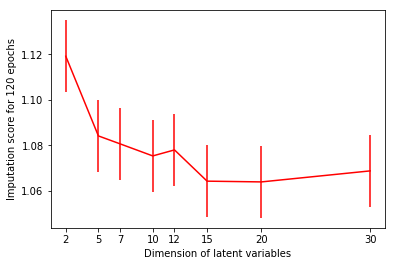

In [78]:
import numpy as np
import matplotlib.pyplot as plt

N = 8
means = np.mean(results.values(), axis=1)
std = np.std(results.values(), axis=1)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.errorbar(results.keys(), means, color='r', yerr=std[0])

# add some text for labels, title and axes ticks
ax.set_ylabel('Imputation score for 120 epochs')
ax.set_xticks(results.keys())
ax.set_xlabel("Dimension of latent variables")

plt.savefig("imputation_dimension_stability.pdf", dpi=300)

plt.show()

# NB VS ZINB

In [9]:
def train_model(num_epochs, expression_train, expression_test, step, batch_size, kl=1):
    iterep = int(expression_train.shape[0]/float(batch_size))-1
    training_history = {"t_loss":[], "v_loss":[], "time":[], "epoch":[]}
    training_history["n_hidden"] = model.n_hidden
    training_history["model"] = model.__class__.__name__
    training_history["n_input"] = model.n_input
    training_history["dropout_nn"] = model.dropout_rate
    training_history["learning_rate"] = learning_rate
    training_history["dispersion"] = model.dispersion
    training_history["epsilon"] = epsilon
    training_history["n_layers"] = model.n_layers
    begin = time.time()
    
    
    for t in range(iterep * num_epochs):
    
        # arange data in batches
        #x_train, b_train = next_batch(expression_train, batch_train, batch_size)
        #x_test, b_test = next_batch(expression_test, batch_test, batch_size)

        #prepare data dictionaries
        #dic_train = {expression: x_train, batch:b_train.A, training_phase:True, kl_scalar:0}
        #dic_test = {expression: x_test, batch:b_test.A, training_phase:False, kl_scalar:0}
        
        # arange data in batches
        #x_train = next_batch(expression_train, batch_size).astype(np.float32)
        x_train = expression_train[batch_size * (t%iterep) :batch_size * (t%iterep + 1) ].astype(np.float32)
        x_test = next_batch(expression_test, batch_size).astype(np.float32)

        #prepare data dictionaries
        dic_train = {expression: x_train, training_phase:True, kl_scalar:kl}
        dic_test = {expression: x_test,  training_phase:False, kl_scalar:kl} 
        
        # run an optimization set
        _, l_tr = sess.run([step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:
            now = time.time()
            print epoch

            l_t = sess.run((model.loss), feed_dict=dic_test)

            training_history["t_loss"].append(l_tr)
            training_history["v_loss"].append(l_t)
            training_history["time"].append(format_time(int(now-begin)))
            training_history["epoch"].append(epoch)
            
            print 'Train / Test performance:', l_tr, l_t
            print "Elapsed Time:", training_history["time"][-1]
            
            #print eval_likelihood(expression_test, sess, kl=0)
            if np.isnan(l_tr):
                break
    return training_history

In [10]:
n_cells = 10000
expression_train = f["data_train"][:n_cells]
#expression_train = f["data_train"]
batch_size = 128
learning_rate = 0.005
epsilon = 0.01

res = {True:[], False:[]}

for i in range(20):
    if i < 10:
        zi = False
    else:
        zi = True
        
    tf.reset_default_graph()
    expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
    kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
    training_phase = tf.placeholder(tf.bool, (), name='training_phase')

    model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                             optimize_algo=optimizer, phase=training_phase, \
                              library_size_mean=mean, library_size_var=var, \
                              n_layers=1, n_hidden=128, zi=zi)

    # Session creation
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    train_model(120, expression_train, expression_test, model.train_step, batch_size, kl=1)
    res[zi].append(eval_likelihood(expression_test, sess, kl=1))

Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18096.7 4549.92
Elapsed Time: 0:00:00
1
Train / Test performance: 1848.88 3069.31
Elapsed Time: 0:00:00
2
Train / Test performance: 1663.86 1830.47
Elapsed Time: 0:00:01
3
Train / Test performance: 1515.27 1477.7
Elapsed Time: 0:00:02
4
Train / Test performance: 1487.21 1463.06
Elapsed Time: 0:00:02
5
Train / Test performance: 1448.53 1409.1
Elapsed Time: 0:00:03
6
Train / Test performance: 1419.03 1464.78
Elapsed Time: 0:00:04
7
Train / Test performance: 1390.57 1353.59
Elapsed Time: 0:00:04
8
Train / Test performance: 1363.91 1422.78
Elapsed Time: 0:00:05
9
Train / Test performance: 1359.22 1450.57
Elapsed Time: 0:00:05
10
Train / Test performance: 1352.58 1347.79
Elapsed Time: 0:00:06
11
Train / Test performance: 1330.1 

119
Train / Test performance: 1180.27 1179.43
Elapsed Time: 0:01:15
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 17516.5 5895.56
Elapsed Time: 0:00:00
1
Train / Test performance: 1830.28 3065.05
Elapsed Time: 0:00:00
2
Train / Test performance: 1721.48 1770.2
Elapsed Time: 0:00:01
3
Train / Test performance: 1570.19 1553.32
Elapsed Time: 0:00:02
4
Train / Test performance: 1496.87 1460.59
Elapsed Time: 0:00:02
5
Train / Test performance: 1440.84 1410.92
Elapsed Time: 0:00:03
6
Train / Test performance: 1415.68 1418.67
Elapsed Time: 0:00:03
7
Train / Test performance: 1398.46 1423.14
Elapsed Time: 0:00:04
8
Train / Test performance: 1374.45 1370.65
Elapsed Time: 0:00:05
9
Train / Test performance: 1379.5 1382.05
Elapsed Time: 0:00:05
10
Train / Test performance: 1363.6

118
Train / Test performance: 1177.31 1168.91
Elapsed Time: 0:01:14
119
Train / Test performance: 1180.3 1141.62
Elapsed Time: 0:01:15
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18301.2 2.97564e+08
Elapsed Time: 0:00:00
1
Train / Test performance: 1887.26 2185.17
Elapsed Time: 0:00:00
2
Train / Test performance: 1626.24 1700.4
Elapsed Time: 0:00:01
3
Train / Test performance: 1506.17 1513.42
Elapsed Time: 0:00:02
4
Train / Test performance: 1450.35 1500.51
Elapsed Time: 0:00:02
5
Train / Test performance: 1432.07 1466.16
Elapsed Time: 0:00:03
6
Train / Test performance: 1412.49 1426.75
Elapsed Time: 0:00:03
7
Train / Test performance: 1420.82 1362.13
Elapsed Time: 0:00:04
8
Train / Test performance: 1357.79 1391.09
Elapsed Time: 0:00:05
9
Train / Test performance: 1

117
Train / Test performance: 1178.29 1166.07
Elapsed Time: 0:01:13
118
Train / Test performance: 1182.04 1157.53
Elapsed Time: 0:01:14
119
Train / Test performance: 1179.65 1172.68
Elapsed Time: 0:01:14
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 17681.1 4815.24
Elapsed Time: 0:00:00
1
Train / Test performance: 1848.44 3514.47
Elapsed Time: 0:00:00
2
Train / Test performance: 1641.31 1736.91
Elapsed Time: 0:00:01
3
Train / Test performance: 1514.63 1500.8
Elapsed Time: 0:00:01
4
Train / Test performance: 1509.78 1513.56
Elapsed Time: 0:00:02
5
Train / Test performance: 1448.77 1405.43
Elapsed Time: 0:00:03
6
Train / Test performance: 1439.95 1409.98
Elapsed Time: 0:00:03
7
Train / Test performance: 1405.58 1377.85
Elapsed Time: 0:00:04
8
Train / Test performance: 13

116
Train / Test performance: 1178.26 1184.34
Elapsed Time: 0:01:13
117
Train / Test performance: 1177.27 1156.16
Elapsed Time: 0:01:13
118
Train / Test performance: 1178.46 1173.35
Elapsed Time: 0:01:14
119
Train / Test performance: 1178.8 1177.86
Elapsed Time: 0:01:15
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18613.5 4116.4
Elapsed Time: 0:00:00
1
Train / Test performance: 1995.4 4185.93
Elapsed Time: 0:00:00
2
Train / Test performance: 1631.33 1948.43
Elapsed Time: 0:00:01
3
Train / Test performance: 1560.21 1482.77
Elapsed Time: 0:00:02
4
Train / Test performance: 1497.45 1638.82
Elapsed Time: 0:00:02
5
Train / Test performance: 1454.67 1495.99
Elapsed Time: 0:00:03
6
Train / Test performance: 1451.82 1495.22
Elapsed Time: 0:00:03
7
Train / Test performance: 13

115
Train / Test performance: 1178.11 1194.53
Elapsed Time: 0:01:12
116
Train / Test performance: 1182.38 1179.34
Elapsed Time: 0:01:13
117
Train / Test performance: 1181.24 1168.13
Elapsed Time: 0:01:13
118
Train / Test performance: 1179.53 1149.27
Elapsed Time: 0:01:14
119
Train / Test performance: 1180.94 1199.74
Elapsed Time: 0:01:15
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18409.5 4075.95
Elapsed Time: 0:00:00
1
Train / Test performance: 1893.28 3609.93
Elapsed Time: 0:00:00
2
Train / Test performance: 1598.05 1812.76
Elapsed Time: 0:00:01
3
Train / Test performance: 1520.66 1657.09
Elapsed Time: 0:00:01
4
Train / Test performance: 1548.69 1606.56
Elapsed Time: 0:00:02
5
Train / Test performance: 1493.68 1510.74
Elapsed Time: 0:00:03
6
Train / Test performanc

114
Train / Test performance: 1183.48 1183.97
Elapsed Time: 0:01:11
115
Train / Test performance: 1182.57 1153.85
Elapsed Time: 0:01:12
116
Train / Test performance: 1179.6 1192.4
Elapsed Time: 0:01:13
117
Train / Test performance: 1180.4 1143.03
Elapsed Time: 0:01:13
118
Train / Test performance: 1179.1 1171.28
Elapsed Time: 0:01:14
119
Train / Test performance: 1181.75 1174.75
Elapsed Time: 0:01:14
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 17427.6 6878.71
Elapsed Time: 0:00:00
1
Train / Test performance: 1863.17 4755.78
Elapsed Time: 0:00:00
2
Train / Test performance: 1676.27 1747.59
Elapsed Time: 0:00:01
3
Train / Test performance: 1613.0 1410.4
Elapsed Time: 0:00:01
4
Train / Test performance: 1517.49 1526.6
Elapsed Time: 0:00:02
5
Train / Test performance: 14

114
Train / Test performance: 1179.08 1206.86
Elapsed Time: 0:01:11
115
Train / Test performance: 1180.91 1173.11
Elapsed Time: 0:01:12
116
Train / Test performance: 1178.57 1141.74
Elapsed Time: 0:01:12
117
Train / Test performance: 1181.15 1186.87
Elapsed Time: 0:01:13
118
Train / Test performance: 1179.2 1197.65
Elapsed Time: 0:01:14
119
Train / Test performance: 1178.67 1176.78
Elapsed Time: 0:01:14
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18141.0 3982.49
Elapsed Time: 0:00:00
1
Train / Test performance: 1862.51 3888.49
Elapsed Time: 0:00:00
2
Train / Test performance: 1638.23 1653.78
Elapsed Time: 0:00:01
3
Train / Test performance: 1568.03 1518.23
Elapsed Time: 0:00:02
4
Train / Test performance: 1516.37 1460.7
Elapsed Time: 0:00:02
5
Train / Test performanc

113
Train / Test performance: 1177.66 1138.13
Elapsed Time: 0:01:11
114
Train / Test performance: 1180.07 1266.42
Elapsed Time: 0:01:12
115
Train / Test performance: 1180.85 1149.49
Elapsed Time: 0:01:12
116
Train / Test performance: 1178.78 1156.18
Elapsed Time: 0:01:13
117
Train / Test performance: 1182.28 1194.32
Elapsed Time: 0:01:14
118
Train / Test performance: 1181.09 1160.15
Elapsed Time: 0:01:14
119
Train / Test performance: 1181.25 1206.54
Elapsed Time: 0:01:15
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18032.8 4283.88
Elapsed Time: 0:00:00
1
Train / Test performance: 1830.84 2873.85
Elapsed Time: 0:00:00
2
Train / Test performance: 1624.44 1742.4
Elapsed Time: 0:00:01
3
Train / Test performance: 1539.45 1705.89
Elapsed Time: 0:00:02
4
Train / Test perform

112
Train / Test performance: 1182.8 1148.77
Elapsed Time: 0:01:10
113
Train / Test performance: 1180.9 1158.72
Elapsed Time: 0:01:10
114
Train / Test performance: 1182.05 1153.46
Elapsed Time: 0:01:11
115
Train / Test performance: 1181.84 1177.92
Elapsed Time: 0:01:12
116
Train / Test performance: 1186.16 1152.12
Elapsed Time: 0:01:12
117
Train / Test performance: 1182.46 1165.14
Elapsed Time: 0:01:13
118
Train / Test performance: 1181.49 1160.59
Elapsed Time: 0:01:14
119
Train / Test performance: 1183.75 1157.09
Elapsed Time: 0:01:14
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18048.9 4519.4
Elapsed Time: 0:00:00
1
Train / Test performance: 1961.88 3455.52
Elapsed Time: 0:00:00
2
Train / Test performance: 1619.52 1845.45
Elapsed Time: 0:00:01
3
Train / Test perform

112
Train / Test performance: 1182.98 1141.66
Elapsed Time: 0:01:10
113
Train / Test performance: 1185.66 1208.13
Elapsed Time: 0:01:10
114
Train / Test performance: 1177.92 1122.39
Elapsed Time: 0:01:11
115
Train / Test performance: 1176.92 1184.92
Elapsed Time: 0:01:12
116
Train / Test performance: 1179.72 1155.8
Elapsed Time: 0:01:12
117
Train / Test performance: 1182.29 1161.45
Elapsed Time: 0:01:13
118
Train / Test performance: 1178.36 1163.08
Elapsed Time: 0:01:14
119
Train / Test performance: 1183.43 1150.44
Elapsed Time: 0:01:14
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 17926.6 3910.59
Elapsed Time: 0:00:00
1
Train / Test performance: 1828.57 2726.46
Elapsed Time: 0:00:00
2
Train / Test performance: 1583.12 1734.57
Elapsed Time: 0:

111
Train / Test performance: 1175.4 1191.69
Elapsed Time: 0:01:18
112
Train / Test performance: 1181.55 1132.05
Elapsed Time: 0:01:19
113
Train / Test performance: 1180.22 1218.3
Elapsed Time: 0:01:20
114
Train / Test performance: 1178.31 1181.89
Elapsed Time: 0:01:20
115
Train / Test performance: 1177.13 1155.77
Elapsed Time: 0:01:21
116
Train / Test performance: 1174.33 1162.64
Elapsed Time: 0:01:22
117
Train / Test performance: 1177.86 1164.61
Elapsed Time: 0:01:22
118
Train / Test performance: 1174.77 1142.33
Elapsed Time: 0:01:23
119
Train / Test performance: 1179.31 1130.11
Elapsed Time: 0:01:24
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18368.3 4422.24
Elapsed Time: 0:00:00
1
Train / Test performance: 1802.74 3370.22
Elapsed Time: 0

110
Train / Test performance: 1174.95 1152.03
Elapsed Time: 0:01:17
111
Train / Test performance: 1179.2 1170.74
Elapsed Time: 0:01:18
112
Train / Test performance: 1175.9 1173.75
Elapsed Time: 0:01:19
113
Train / Test performance: 1178.9 1216.32
Elapsed Time: 0:01:19
114
Train / Test performance: 1175.51 1166.7
Elapsed Time: 0:01:20
115
Train / Test performance: 1178.68 1155.35
Elapsed Time: 0:01:21
116
Train / Test performance: 1176.53 1159.95
Elapsed Time: 0:01:21
117
Train / Test performance: 1182.05 1144.16
Elapsed Time: 0:01:22
118
Train / Test performance: 1176.72 1179.18
Elapsed Time: 0:01:23
119
Train / Test performance: 1173.32 1162.84
Elapsed Time: 0:01:23
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 18035.8 4061.08
Elapsed Time: 0

109
Train / Test performance: 1177.63 1165.34
Elapsed Time: 0:01:16
110
Train / Test performance: 1177.1 1174.75
Elapsed Time: 0:01:17
111
Train / Test performance: 1180.37 1180.23
Elapsed Time: 0:01:17
112
Train / Test performance: 1178.51 1160.02
Elapsed Time: 0:01:18
113
Train / Test performance: 1177.05 1165.81
Elapsed Time: 0:01:19
114
Train / Test performance: 1178.16 1158.44
Elapsed Time: 0:01:19
115
Train / Test performance: 1177.61 1165.3
Elapsed Time: 0:01:20
116
Train / Test performance: 1175.43 1192.55
Elapsed Time: 0:01:21
117
Train / Test performance: 1182.12 1170.17
Elapsed Time: 0:01:22
118
Train / Test performance: 1177.58 1218.82
Elapsed Time: 0:01:22
119
Train / Test performance: 1177.46 1174.66
Elapsed Time: 0:01:23
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 la

108
Train / Test performance: 1174.88 1189.77
Elapsed Time: 0:01:15
109
Train / Test performance: 1179.01 1158.76
Elapsed Time: 0:01:16
110
Train / Test performance: 1177.81 1200.1
Elapsed Time: 0:01:17
111
Train / Test performance: 1176.26 1149.33
Elapsed Time: 0:01:17
112
Train / Test performance: 1182.88 1148.57
Elapsed Time: 0:01:18
113
Train / Test performance: 1180.27 1161.36
Elapsed Time: 0:01:19
114
Train / Test performance: 1177.4 1170.71
Elapsed Time: 0:01:19
115
Train / Test performance: 1178.06 1162.22
Elapsed Time: 0:01:20
116
Train / Test performance: 1178.45 1184.05
Elapsed Time: 0:01:21
117
Train / Test performance: 1177.44 1200.8
Elapsed Time: 0:01:21
118
Train / Test performance: 1172.83 1177.06
Elapsed Time: 0:01:22
119
Train / Test performance: 1176.8 1155.73
Elapsed Time: 0:01:23
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will 

107
Train / Test performance: 1183.11 1163.54
Elapsed Time: 0:01:15
108
Train / Test performance: 1178.53 1195.05
Elapsed Time: 0:01:16
109
Train / Test performance: 1178.73 1206.14
Elapsed Time: 0:01:17
110
Train / Test performance: 1181.01 1174.11
Elapsed Time: 0:01:18
111
Train / Test performance: 1180.98 1171.15
Elapsed Time: 0:01:18
112
Train / Test performance: 1177.42 1127.78
Elapsed Time: 0:01:19
113
Train / Test performance: 1179.2 1186.24
Elapsed Time: 0:01:20
114
Train / Test performance: 1178.11 1134.94
Elapsed Time: 0:01:20
115
Train / Test performance: 1175.86 1190.76
Elapsed Time: 0:01:21
116
Train / Test performance: 1177.7 1157.86
Elapsed Time: 0:01:22
117
Train / Test performance: 1175.81 1173.01
Elapsed Time: 0:01:22
118
Train / Test performance: 1179.91 1140.26
Elapsed Time: 0:01:23
119
Train / Test performance: 1181.68 1174.66
Elapsed Time: 0:01:24
Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library s

106
Train / Test performance: 1181.45 1184.73
Elapsed Time: 0:01:15
107
Train / Test performance: 1177.41 1154.78
Elapsed Time: 0:01:15
108
Train / Test performance: 1183.41 1148.8
Elapsed Time: 0:01:16
109
Train / Test performance: 1182.15 1159.31
Elapsed Time: 0:01:17
110
Train / Test performance: 1180.96 1170.78
Elapsed Time: 0:01:18
111
Train / Test performance: 1179.39 1181.96
Elapsed Time: 0:01:18
112
Train / Test performance: 1179.78 1190.62
Elapsed Time: 0:01:19
113
Train / Test performance: 1174.57 1116.79
Elapsed Time: 0:01:20
114
Train / Test performance: 1177.9 1160.18
Elapsed Time: 0:01:20
115
Train / Test performance: 1172.18 1177.22
Elapsed Time: 0:01:21
116
Train / Test performance: 1173.95 1168.15
Elapsed Time: 0:01:22
117
Train / Test performance: 1177.73 1183.48
Elapsed Time: 0:01:23
118
Train / Test performance: 1176.4 1153.17
Elapsed Time: 0:01:23
119
Train / Test performance: 1174.27 1195.54
Elapsed Time: 0:01:24
Running scVI on 720 genes
scVI will run without bat

105
Train / Test performance: 1181.23 1161.18
Elapsed Time: 0:01:14
106
Train / Test performance: 1176.74 1167.58
Elapsed Time: 0:01:14
107
Train / Test performance: 1175.95 1161.79
Elapsed Time: 0:01:15
108
Train / Test performance: 1178.24 1193.19
Elapsed Time: 0:01:16
109
Train / Test performance: 1176.15 1161.08
Elapsed Time: 0:01:17
110
Train / Test performance: 1179.63 1132.16
Elapsed Time: 0:01:17
111
Train / Test performance: 1179.02 1099.72
Elapsed Time: 0:01:18
112
Train / Test performance: 1178.36 1166.52
Elapsed Time: 0:01:19
113
Train / Test performance: 1179.79 1176.4
Elapsed Time: 0:01:19
114
Train / Test performance: 1177.45 1192.98
Elapsed Time: 0:01:20
115
Train / Test performance: 1178.06 1181.72
Elapsed Time: 0:01:21
116
Train / Test performance: 1177.35 1180.68
Elapsed Time: 0:01:21
117
Train / Test performance: 1174.39 1176.85
Elapsed Time: 0:01:22
118
Train / Test performance: 1177.99 1171.36
Elapsed Time: 0:01:23
119
Train / Test performance: 1181.21 1213.21
Ela

104
Train / Test performance: 1178.9 1177.35
Elapsed Time: 0:01:13
105
Train / Test performance: 1179.42 1185.16
Elapsed Time: 0:01:14
106
Train / Test performance: 1180.71 1157.23
Elapsed Time: 0:01:14
107
Train / Test performance: 1179.57 1145.99
Elapsed Time: 0:01:15
108
Train / Test performance: 1179.62 1140.56
Elapsed Time: 0:01:16
109
Train / Test performance: 1181.45 1173.67
Elapsed Time: 0:01:16
110
Train / Test performance: 1180.06 1238.78
Elapsed Time: 0:01:17
111
Train / Test performance: 1176.11 1201.49
Elapsed Time: 0:01:18
112
Train / Test performance: 1179.39 1162.11
Elapsed Time: 0:01:18
113
Train / Test performance: 1180.66 1126.12
Elapsed Time: 0:01:19
114
Train / Test performance: 1178.7 1188.41
Elapsed Time: 0:01:20
115
Train / Test performance: 1184.37 1182.37
Elapsed Time: 0:01:21
116
Train / Test performance: 1178.66 1175.03
Elapsed Time: 0:01:21
117
Train / Test performance: 1176.95 1187.12
Elapsed Time: 0:01:22
118
Train / Test performance: 1175.71 1138.89
Elap

103
Train / Test performance: 1174.57 1193.04
Elapsed Time: 0:01:12
104
Train / Test performance: 1173.15 1176.36
Elapsed Time: 0:01:13
105
Train / Test performance: 1177.42 1195.13
Elapsed Time: 0:01:14
106
Train / Test performance: 1179.02 1137.05
Elapsed Time: 0:01:14
107
Train / Test performance: 1182.41 1126.76
Elapsed Time: 0:01:15
108
Train / Test performance: 1179.58 1201.13
Elapsed Time: 0:01:16
109
Train / Test performance: 1179.76 1197.78
Elapsed Time: 0:01:17
110
Train / Test performance: 1178.55 1149.52
Elapsed Time: 0:01:17
111
Train / Test performance: 1180.64 1168.35
Elapsed Time: 0:01:18
112
Train / Test performance: 1181.62 1178.03
Elapsed Time: 0:01:19
113
Train / Test performance: 1178.22 1190.27
Elapsed Time: 0:01:19
114
Train / Test performance: 1175.34 1179.41
Elapsed Time: 0:01:20
115
Train / Test performance: 1177.1 1218.82
Elapsed Time: 0:01:21
116
Train / Test performance: 1173.79 1173.2
Elapsed Time: 0:01:22
117
Train / Test performance: 1178.48 1182.57
Elap

102
Train / Test performance: 1178.96 1169.83
Elapsed Time: 0:01:12
103
Train / Test performance: 1178.06 1182.75
Elapsed Time: 0:01:12
104
Train / Test performance: 1176.43 1177.86
Elapsed Time: 0:01:13
105
Train / Test performance: 1179.83 1175.81
Elapsed Time: 0:01:14
106
Train / Test performance: 1177.74 1173.84
Elapsed Time: 0:01:14
107
Train / Test performance: 1179.04 1219.94
Elapsed Time: 0:01:15
108
Train / Test performance: 1175.32 1152.91
Elapsed Time: 0:01:16
109
Train / Test performance: 1176.04 1165.61
Elapsed Time: 0:01:17
110
Train / Test performance: 1178.88 1180.31
Elapsed Time: 0:01:17
111
Train / Test performance: 1174.49 1191.16
Elapsed Time: 0:01:18
112
Train / Test performance: 1175.05 1182.39
Elapsed Time: 0:01:19
113
Train / Test performance: 1176.66 1145.84
Elapsed Time: 0:01:19
114
Train / Test performance: 1177.93 1132.35
Elapsed Time: 0:01:20
115
Train / Test performance: 1182.91 1172.56
Elapsed Time: 0:01:21
116
Train / Test performance: 1176.78 1177.26
El

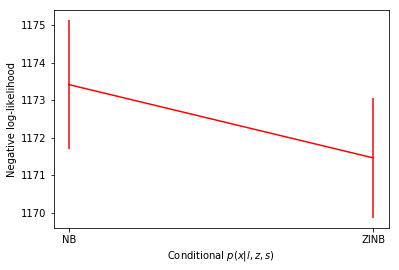

In [18]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
means = np.mean(res.values(), axis=1)
std = np.std(res.values(), axis=1)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.errorbar(ind, means, color='r', yerr=std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Negative log-likelihood')
ax.set_xticks(ind)
ax.set_xticklabels(["NB", "ZINB"])
ax.set_xlabel("Conditional $p(x | l, z, s)$")

plt.savefig("ZINB_vs_NB.pdf", dpi=300)

plt.show()